In [1]:
import os
import numpy as np
import wandb
from wandb.keras import WandbCallback
from keras import callbacks
import keras
import DeepSetNeuralNetArchitecture as DSNNA
import ParticleTransformer as ParT
from DeepSetNeuralNetArchitecture import PredictOnEpoch
import ConvolutionalRecurrentNeuralNetworkArchitecture as CRNNA
from DeepSetNeuralNetArchitecture import LogNormal_Loss_Function
from DeepSetNeuralNetArchitecture import Mean_Squared_Error
import keras.backend as k
import uproot
import awkward as ak
import sklearn as sk
from numpy.lib.recfunctions import structured_to_unstructured
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.preprocessing import StandardScaler
import pandas as pd
from hffrag import fixedbinning
from hffrag import binneddensity
from keras.utils.vis_utils import plot_model
from timeit import default_timer as timer
import matplotlib.pyplot as plt
%matplotlib inline

2023-01-13 14:05:08.835689: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-13 14:05:09.003546: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-13 14:05:09.007901: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-13 14:05:09.007916: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

number of jets to train on:
141329


/home/physics/phujdj/DeepLearningParticlePhysics/hffrag.py:136: RuntimeWarning: overflow encountered in sinh
  pzs = numpy.where(mask, pts, pts * numpy.sinh(etas))
/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
wandb.init(project = "hffrag-DeepSetsNeuralNetworkArchitecture")

wandb: Currently logged in as: kaylendarnbrook. Use `wandb login --relogin` to force relogin


In [3]:
# The data is being stored in a tree datastructure.
# We access the charm root using this command
tree = uproot.open("hffrag.root:CharmAnalysis")

In [4]:
# Initial parameters
MASKVAL = -999 # This value is introduced to ensure arrays are regular (Of the same size). They will be masked later by the network
MAXTRACKS = 32 # This value is the maximum number of tracks allowed per event
BATCHSIZE = 64 # This is the batch size of the mini batches used during training
EPOCHS = 100 # This is the default number of epochs for which the neural network will train providing that early stopping does not occur
MAXEVENTS = 1e20 #This is the maximum number of events that will the program will accept
LR = 1e-5 #This is the default learning rate
num_layers = 4
d_model = 8
dff = 512
num_heads = 8
n_targets = 3
dropout_rate = 0.1

In [5]:
wandb.config = {
    "learning_rate": LR,
    "epochs":EPOCHS,
    "batch_size":BATCHSIZE,
    "max_events": MAXEVENTS,
    "MAXTRACKS": MAXTRACKS,
    "num_layers": num_layers,
    "d_model": d_model,
    "dff": dff,
    "dropout_rate": dropout_rate,
    "n_targets": n_targets
}

In [6]:
# Select the features we wish to study
track_features = ["AnalysisTracks_pt", "AnalysisTracks_eta", "AnalysisTracks_phi", "AnalysisTracks_z0sinTheta",
                  "AnalysisTracks_d0sig", "AnalysisTracks_d0", "AnalysisTracks_d0sigPV", "AnalysisTracks_d0PV"]
jet_features = ["AnalysisAntiKt4TruthJets_pt", "AnalysisAntiKt4TruthJets_eta", "AnalysisAntiKt4TruthJets_phi",
                "AnalysisAntiKt4TruthJets_ghostB_pt", "AnalysisAntiKt4TruthJets_ghostB_eta","AnalysisAntiKt4TruthJets_ghostB_phi"]

In [7]:
# Read in the dat from the root file
features = tree.arrays(jet_features+track_features, entry_stop=MAXEVENTS)

In [8]:
# Select the events of interest
events = features[ak.sum(
    features["AnalysisAntiKt4TruthJets_pt"] > 25000, axis=1) > 0]

In [9]:
# Displays the number of jets being trained on
jets = events[jet_features][:, 0]
print("The number of jets to train on is: ", len(jets))
print("The number of track features is: ",len(track_features))

The number of jets to train on is:  141329
The number of track features is:  8


In [10]:
# Select tracks from the events
tracks = events[track_features]

# Match the tracks to the jets
matchedtracks = tracks[DSNNA.Match_Tracks(jets, tracks)]

# Pad and Flatten the data
matchedtracks = DSNNA.flatten(matchedtracks, MAXTRACKS)

In [11]:
# Identify the the bottom jets and their associated tracks
bjets = ak.sum(jets["AnalysisAntiKt4TruthJets_ghostB_pt"] > 5000, axis=1) > 0
jets = jets[bjets]

# Obtain the pt, eta and phi of each b hadron jet
bhads_pt = jets["AnalysisAntiKt4TruthJets_ghostB_pt"][:, 0].to_numpy()
bhads_eta = jets["AnalysisAntiKt4TruthJets_ghostB_eta"][:,0].to_numpy()
bhads_phi = jets["AnalysisAntiKt4TruthJets_ghostB_phi"][:,0].to_numpy()

bhads = np.stack([bhads_pt,bhads_eta,bhads_phi],axis = -1) #Combine the momentum, eta and phi for each jet into one array

print("There are {} outputs".format(np.shape(bhads)[1])) # Display the number of target features the neural network will predict
matchedtracks = matchedtracks[bjets]
print("There are {} inputs".format(np.shape(matchedtracks)[1])) # Display the number of target features the neural network will use in it's ppredictions

There are 3 outputs
There are 32 inputs


In [12]:
# Transform the jet and tracks to unstructed data.
jets = structured_to_unstructured(jets[jet_features[:-3]])
matchedtracks = structured_to_unstructured(matchedtracks)

In [13]:
# Convert the coordinates of the b jets and tracks to cartesian coordinates
tracks_p = DSNNA.pt_eta_phi_2_px_py_pz_tracks(matchedtracks.to_numpy())
bhads = DSNNA.pt_eta_phi_2_px_py_pz_jets(bhads)

#Combine the momenta of the tracks with the rest of the track features to form the track dataset
tracks = np.concatenate([tracks_p,matchedtracks[:,:,3:].to_numpy()],axis = 2)

/home/physics/phujdj/DeepLearningParticlePhysics/DeepSetNeuralNetArchitecture.py:103: RuntimeWarning: overflow encountered in sinh
  pzs = np.where(mask1 | mask3, pts, pts * np.sinh(etas))


In [14]:
Scaler = StandardScaler()
Num_events,Num_tracks,Num_features = np.shape(tracks)
tracks = np.reshape(tracks, newshape=(-1,Num_features))
tracks = Scaler.fit_transform(tracks)
tracks = np.reshape(tracks, newshape= (Num_events,Num_tracks,Num_features))

In [15]:
# Split the data into training and validation sets.
X_train, X_valid, y_train, y_valid = train_test_split(
    tracks, bhads, train_size=0.8, random_state=42)

In [16]:
X_train_event, y_train_event = np.array([X_train[0]]), np.array([y_train[0]])
X_valid_event, y_valid_event = np.array([X_valid[0]]), np.array([y_valid[0]])
print(np.shape(X_train),np.shape(y_train))
print(np.shape(X_train_event),np.shape(y_train_event))

(54514, 32, 8) (54514, 3)
(1, 32, 8) (1, 3)


In [17]:
#Check for the of the training and validation sets
print(np.shape(X_train), np.shape(X_valid))
print(np.shape(y_train), np.shape(y_valid))

(54514, 32, 8) (13629, 32, 8)
(54514, 3) (13629, 3)


In [18]:
#Save the training and validation datasets.
np.save("/home/physics/phujdj/DeepLearningParticlePhysics/TrainingAndValidationData/X_train_data.npy",X_train)
np.save("/home/physics/phujdj/DeepLearningParticlePhysics/TrainingAndValidationData/X_valid_data.npy",X_valid)
np.save("/home/physics/phujdj/DeepLearningParticlePhysics/TrainingAndValidationData/y_train_data.npy",y_train)
np.save("/home/physics/phujdj/DeepLearningParticlePhysics/TrainingAndValidationData/y_valid_data.npy",y_valid)

In [19]:
class TransformerSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs = {}):
        self.logs = []
    def on_epoch_begin(self, epoch, logs ={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs = {}):
        self.logs.append(timer() - self.starttime)

In [20]:
ParticleTranformer = ParT.Transformer(
    num_layers = num_layers, 
    d_model = d_model, 
    num_heads=num_heads,
    MASKVAL= MASKVAL,
    dff = dff,
    n_targets= n_targets)

2023-01-13 14:07:09.499760: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-13 14:07:09.499794: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-13 14:07:09.499816: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vonneumann.csc.warwick.ac.uk): /proc/driver/nvidia/version does not exist
2023-01-13 14:07:09.500405: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
learning_rating = TransformerSchedule(d_model)
optimizer = tf.keras.optimizers.Nadam(learning_rate=LR, beta_1 = 0.9, beta_2 = 0.98, epsilon = 1e-9)

In [22]:
ParticleTranformer.compile(
    optimizer=optimizer,
    loss = LogNormal_Loss_Function
)

Text(0.5, 0, 'Train Step')

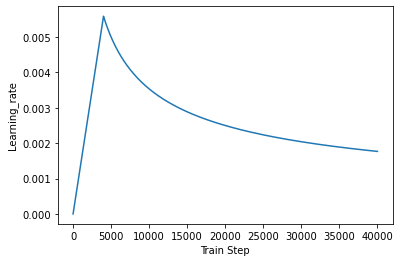

In [23]:
plt.plot(learning_rating(tf.range(40000,dtype = tf.float32)))
plt.ylabel("Learning_rate")
plt.xlabel("Train Step")

In [24]:
output = ParticleTranformer((X_train,X_train))
ParticleTranformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  43968     
                                                                 
 decoder (Decoder)           multiple                  53024     
                                                                 
 dense_16 (Dense)            multiple                  81        
                                                                 
Total params: 97,073
Trainable params: 97,073
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Introduce early_stopping to prevent overfitting
early_stopping = callbacks.EarlyStopping(
    min_delta=0.00001,  # The minimum amount of change to count as an improvement
    patience=30,  # The number of epochs to wait before stopping
    restore_best_weights=True,  # Keep the best weights
)
# Prevent spikes in the validation and training loss due to the gradient descent kicking the network out of a local minima
reduce_learn_on_plateau = callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.80, patience=10, min_lr=1e-8)

# Save the weights of the model to allow reuse in future.
path = "/home/physics/phujdj/DeepLearningParticlePhysics/CheckPoints_2/DeepNetWeights&Biases.ckpt"
checkpoint_dir = os.path.dirname(path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=path,
                                                 save_weights_only=True, verbose=0, save_freq = 100*BATCHSIZE)
#Timer
cb = TimingCallback()

#Weight&Biases Callback:
Wanda = WandbCallback(save_graph = True,save_weights_only = True, log_weights = True, log_gradients = True, log_evaluation = True, training_data = ((X_train,X_train),y_train), validation_data = ((X_valid,X_valid,),y_valid), log_batch_frequency = 5)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


In [26]:
# Train the neural network
Training_data = (X_train,X_train)
Validation_data = (X_valid,X_valid)
history = ParticleTranformer.fit(
    Training_data, y_train,
    validation_data=(Validation_data,y_valid),
    batch_size=BATCHSIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping,reduce_learn_on_plateau,cb,cp_callback],
    use_multiprocessing=True
)

Epoch 1/100


TypeError: in user code:

    File "/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/physics/phujdj/DeepLearningParticlePhysics/DeepSetNeuralNetArchitecture.py", line 190, in LogNormal_Loss_Function  *
        epilson = tf.constant(keras.backend.epsilon(), shape = (np.shape(true)[0],))
    File "<__array_function__ internals>", line 5, in prod
        
    File "/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 3030, in prod
        return _wrapreduction(a, np.multiply, 'prod', axis, dtype, out,
    File "/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 87, in _wrapreduction
        return ufunc.reduce(obj, axis, dtype, out, **passkwargs)

    TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'


In [ ]:
# Plot the loss and validation curves vs epoch
history_df = pd.DataFrame(history.history)
np.log(history_df.loc[:, ["loss","val_loss"]]).plot()
history_df.to_csv('/home/physics/phujdj/DeepLearningParticlePhysics/history.csv')

In [ ]:
print(sum(cb.logs))

In [ ]:
# Output to the console the minimum epoch
print("Minimum validation loss: {}".format(history_df["loss"].min()))

In [ ]:
#Evaluate the entire performance of the model
loss = ParT.evaluate((tracks,tracks),bhads,verbose = 2)
print("The Loaded DeepNet has loss: ", loss)